In [1]:
% matplotlib inline

from __future__ import division

import glob
import numpy as np
from collections import namedtuple
from fractions import Fraction

import colour
from colour.plotting import *

from colour_hdri.exif import get_exif_data
from colour_hdri.merge import merge_to_hdri
from colour_hdri.weighting_functions import (
    hat_function,
    normal_distribution_function,
    weighting_function_Debevec1997)
    

DIRECTORY = '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/resources/NIKON D800/Cube_001/'

OECF = colour.RGB_COLOURSPACES['sRGB'].transfer_function

ExifData = namedtuple('ExifData', ('aperture', 'shutter_speed', 'iso'))

Image = namedtuple('Image', ('path', 'data', 'exif_data'))


def process1(dng_files):
    print('Reading Images...')
    images = []
    for dng_file in dng_files:
        exif_data = get_exif_data(dng_file)
        aperture = float(exif_data['EXIF']['Aperture Value'][0])
        shutter_speed = float(Fraction(
            exif_data['EXIF']['Shutter Speed Value'][0]))
        iso = float(exif_data['EXIF']['ISO'][0])

        images.append(Image(dng_file,
                            colour.read_image(dng_file.replace('dng', 'tiff')),
                            ExifData(aperture, shutter_speed, iso)))
        
    return images

IMAGES = process1(dng_files = glob.glob('{0}/*.dng'.format(DIRECTORY)))

Reading Images...


Merging Images...


/Users/kelsolaar/Documents/Development/Environments/colour-hdri/lib/python2.7/site-packages/colour_hdri/merge.py:30: RuntimeWarning: invalid value encountered in true_divide
  image_c /= weight_c


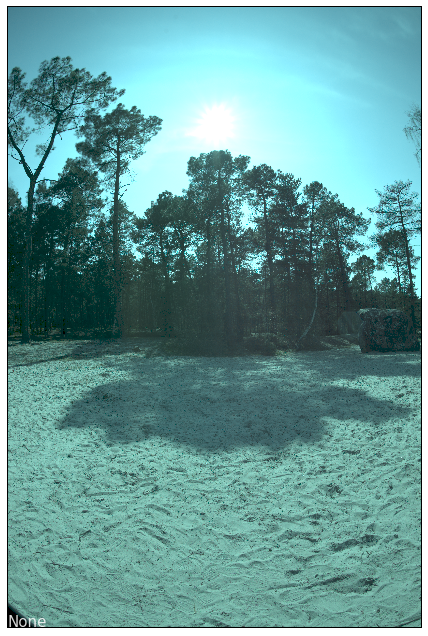

In [2]:
def custom_weight_function(a):
    a = np.asarray(a)

    return np.where(a < 0.5,
                   weighting_function_Debevec1997(a),
                   1)


def process2(images):
    print('Merging Images...')
    image = merge_to_hdri(images, custom_weight_function)


    image_plot(OECF(image))

    colour.write_image(image, '{0}/Merge.exr'.format(DIRECTORY))

process2(IMAGES)

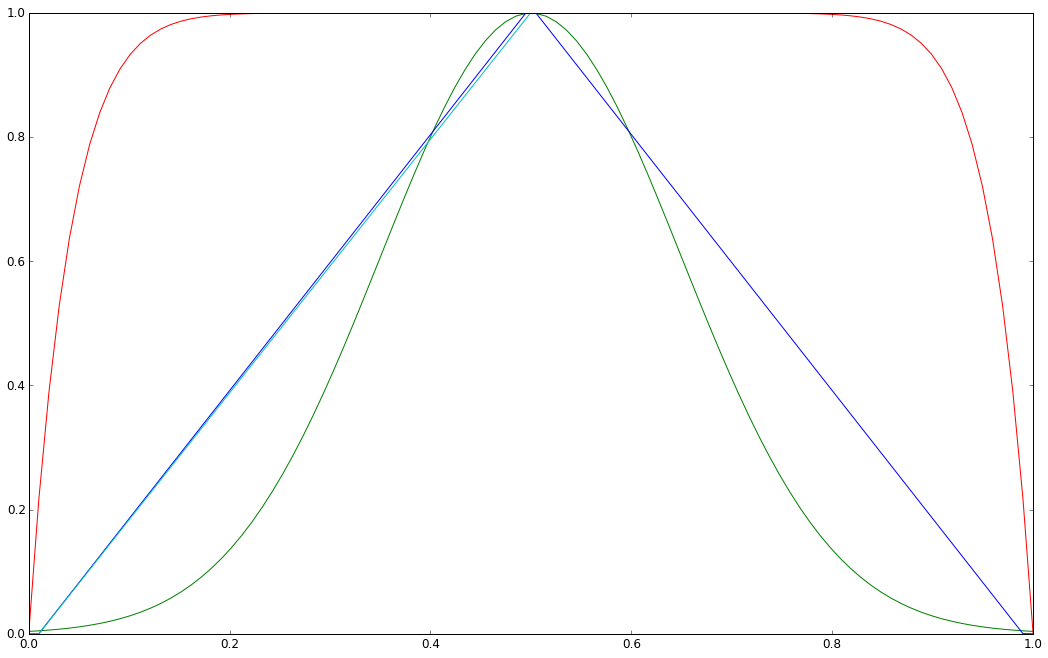

In [3]:
import pylab

pylab.plot(np.linspace(0, 1, 100), hat_function(np.linspace(0, 1, 100)), label='Hat')
pylab.plot(np.linspace(0, 1, 100), normal_distribution_function(np.linspace(0, 1, 100)), label='Normal')
pylab.plot(np.linspace(0, 1, 100), weighting_function_Debevec1997(np.linspace(0, 1, 100)), label='Debevec (1997)')
pylab.plot(np.linspace(0, 1, 1000), custom_weight_function(np.linspace(0, 1, 1000)), label='Custom')

pylab.show()